DEVICE: cuda
Estações próximas (<30km): 1


/tmp/ipykernel_68756/2864786883.py:174: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_daily_mean = df_hourly_all.set_index("Data").resample("H").mean(numeric_only=True)  # garante numérico por hora


df_diario (head):
        data  temperatura  radiacao_global_kj_m2  \
0 2019-01-01    20.520833                15506.3   
1 2019-01-02    22.716667                29912.7   
2 2019-01-03    24.341667                26689.6   
3 2019-01-04    23.425000                22159.8   
4 2019-01-05    20.866667                11529.8   

   pressao_atmosferica_ao_nivel_da_estacao_horaria_mb  \
0                                         888.025000    
1                                         888.804167    
2                                         887.620833    
3                                         887.541667    
4                                         887.962500    

   umidade_relativa_do_ar_horaria  
0                       82.208333  
1                       71.041667  
2                       56.208333  
3                       61.375000  
4                       77.250000  
Semanas válidas: 5 | Exógenas: 3 -> ['radiacao_global_kj_m2', 'pressao_atmosferica_ao_nivel_da_estacao_horaria

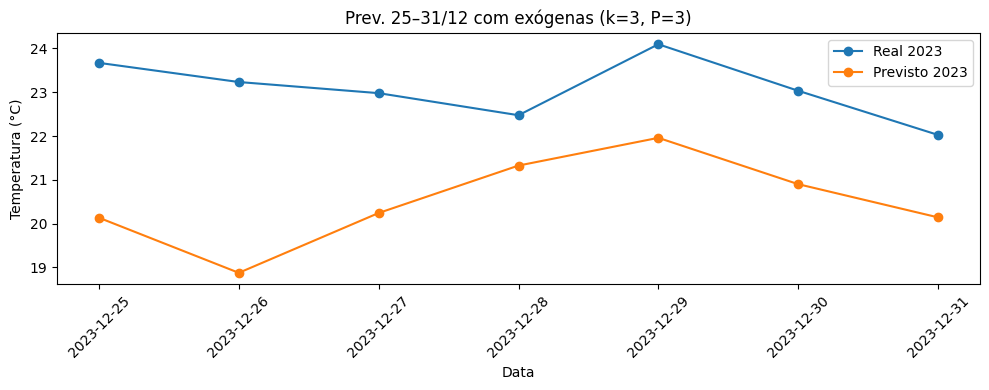

In [5]:
# ===============================================
# PREVISÃO 25–31/12 USANDO k ANOS DE HISTÓRICO + EXÓGENAS
# ===============================================

# --------- IMPORTS BÁSICOS ---------
import os
import re
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# ML / DL
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# --------- CONFIG GERAL ---------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# --------- PARTE 0: UTILITÁRIOS ---------
def slugify(name: str) -> str:
    """Normaliza nomes de coluna: minúsculas, sem acento, troca espaços/símbolos por '_'."""
    s = unicodedata.normalize("NFKD", name).encode("ascii", "ignore").decode("ascii")
    s = s.lower()
    s = re.sub(r"[^a-z0-9]+", "_", s).strip("_")
    return s

def calculate_distance_from_point_to_station(row,
                                             given_point_coord=(-15.760063, -47.871154)):
    station_coord = (row['LATITUDE:'], row['LONGITUDE:'])
    return geodesic(station_coord, given_point_coord).kilometers

def build_agg_spec(exog_vars):
    """
    Define agregação por coluna nas exógenas:
      - se contiver 'radiacao' -> 'sum'
      - caso contrário -> 'mean'
    Retorna:
      exog_agg: {col_original: agg}
      exog_rename: {col_original: nome_slug}
    """
    agg = {}
    rename = {}
    for col in exog_vars:
        col_limp = slugify(col)
        if "radiacao" in col_limp:
            agg[col] = "sum"
        else:
            agg[col] = "mean"
        rename[col] = col_limp
    return agg, rename

def resample_daily_with_exog(df_raw, temperature_col, exog_vars,
                             fill_mode="interpolate", interp_limit=2):
    """
    df_raw: DF horário. Precisa ter coluna 'Data' (ou 'data') OU índice datetime.
    temperature_col: nome da coluna de temperatura (original, não slug).
    exog_vars: lista com nomes originais das colunas exógenas.
    Retorna df diário com colunas:
      'data', 'temperatura', e exógenas slugificadas.
    """
    df = df_raw.copy()

    # Detecta "data"/"Data" como coluna OU usa índice datetime
    date_col = None
    for c in df.columns:
        if c.lower() == "data":
            date_col = c
            break

    if date_col is not None:
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
        df = df.dropna(subset=[date_col]).set_index(date_col)
    else:
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError("df_raw precisa ter coluna 'data'/'Data' ou índice datetime.")
        df.index = pd.to_datetime(df.index, errors="coerce")
        df = df[~df.index.isna()]

    # Coage as colunas a numérico
    cols_needed = [temperature_col] + exog_vars
    for c in cols_needed:
        if c not in df.columns:
            df[c] = np.nan
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Agrega
    exog_agg, exog_rename = build_agg_spec(exog_vars)
    agg_dict = {temperature_col: "mean", **exog_agg}

    daily = df.resample("D").agg(agg_dict)

    # Renomeia
    rename_map = {temperature_col: "temperatura", **exog_rename}
    daily = daily.rename(columns=rename_map)

    # Reindexa calendário e trata faltantes
    full_idx = pd.date_range(daily.index.min(), daily.index.max(), freq="D")
    daily = daily.reindex(full_idx)

    if fill_mode == "interpolate":
        daily = daily.interpolate(method="time", limit=interp_limit)
    elif fill_mode == "ffill":
        daily = daily.ffill()
    elif fill_mode == "bfill":
        daily = daily.bfill()

    return daily.reset_index().rename(columns={"index": "data"})

# --------- PARTE 1: CARREGAMENTO DOS DADOS HORÁRIOS (2019–2024) ---------
# Ajuste estes caminhos conforme seu ambiente
PATH_ALL_STATIONS = "./data/all_stations.csv"
BASE_DIR = "./data/cleaned_data"
YEARS = [2019, 2020, 2021, 2022, 2023]
SUBDIR_PATTERN = "{year}_cleaned"  # ex.: "2019_cleaned"

# Colunas de interesse
temperature_col = "TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)"
exog_vars = [
    "RADIACAO GLOBAL (KJ/m²)",
    "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",
    "UMIDADE RELATIVA DO AR, HORARIA (%)",
]

# Carrega metadados de estações
df_all_stations = pd.read_csv(PATH_ALL_STATIONS, decimal=",", sep=";")
df_all_stations["Distancia"] = df_all_stations.apply(
    calculate_distance_from_point_to_station, axis=1
)
# Filtra estações a até 30 km
df_nearest_stations = df_all_stations[df_all_stations["Distancia"] < 30].copy()
print("Estações próximas (<30km):", len(df_nearest_stations))

# Lê arquivos horários por estação e por ano
weather_frames = []
for filename in df_nearest_stations['Arquivo']:
    # filename típico: "A123_2019_algo.csv" (ajuste se seu padrão for outro)
    for year in YEARS:
        year_dir = os.path.join(BASE_DIR, SUBDIR_PATTERN.format(year=year))
        # Se o arquivo base é de 2019, trocamos "2019" pelo ano alvo
        fname_year = filename.replace("2019", str(year))
        file_path = os.path.join(year_dir, fname_year)
        if not os.path.exists(file_path):
            # fallback: tenta sem replace (caso já venha certo)
            file_path = os.path.join(year_dir, filename)
        if os.path.exists(file_path):
            df_y = pd.read_csv(file_path, decimal=".", sep=";")
            weather_frames.append(df_y)
        else:
            print("[AVISO] Arquivo não encontrado:", file_path)

if not weather_frames:
    raise FileNotFoundError("Nenhum arquivo horário encontrado. Verifique os caminhos.")

df_hourly_all = pd.concat(weather_frames, ignore_index=True)

# Limpeza simples
if "Hora UTC" in df_hourly_all.columns:
    df_hourly_all = df_hourly_all.drop(columns=["Hora UTC"])
# Garante a coluna Data
if "Data" not in df_hourly_all.columns:
    raise KeyError("Não encontrei coluna 'Data' nos arquivos horários.")

df_hourly_all["Data"] = pd.to_datetime(df_hourly_all["Data"], errors="coerce")
df_hourly_all = df_hourly_all.dropna(subset=["Data"]).sort_values("Data")

# --------- PARTE 2: RESAMPLE DIÁRIO (temperatura + exógenas) ---------
# Primeiro, agregamos por dia com média (porque alguns arquivos podem duplicar registros da estação)
# Em seguida passamos para a função que faz a regra por exógena (sum vs mean) e renomeia.
df_daily_mean = df_hourly_all.set_index("Data").resample("H").mean(numeric_only=True)  # garante numérico por hora
df_daily_mean = df_daily_mean.resample("D").mean()  # média diária simples
df_daily_mean = df_daily_mean.reset_index().rename(columns={"Data": "data"})  # coluna 'data' como exigido

# Agora aplicamos a rotina que re-agrupa corretamente (sum vs mean) e renomeia:
df_diario = resample_daily_with_exog(
    df_raw=df_hourly_all,                 # usa o horário bruto para agregar certo
    temperature_col=temperature_col,
    exog_vars=exog_vars,
    fill_mode="interpolate",
    interp_limit=2
)
print("df_diario (head):")
print(df_diario.head())

# --------- PARTE 3: EXTRAÇÃO DAS SEMANAS 25–31/12 (TEMP + EXÓGENAS) ---------
exog_cols = [slugify(c) for c in exog_vars]  # nomes esperados em df_diario

def extrair_semanas_dezembro_com_exog(df, exog_cols, start_day="12-25", end_day="12-31", impute=True):
    """
    Retorna:
      temps: (N, 7)
      exogs: (N, 7, P)  [P = nº exógenas]
      anos:  (N,)
    - Interpola NaNs dentro da semana por coluna
    - Exige 7 dias completos
    """
    d = df.copy()
    d["data"] = pd.to_datetime(d["data"], errors="coerce")
    d = d.dropna(subset=["data"]).sort_values("data")

    anos = np.sort(d["data"].dt.year.unique())
    T_list, E_list, A_list = [], [], []

    for ano in anos:
        dt_ini = pd.to_datetime(f"{ano}-{start_day}", errors="coerce")
        dt_fim = pd.to_datetime(f"{ano}-{end_day}", errors="coerce")
        sem = d[(d["data"] >= dt_ini) & (d["data"] <= dt_fim)].sort_values("data")

        if len(sem) != 7:
            print(f"[AVISO] {ano}: intervalo {start_day}–{end_day} tem {len(sem)} dia(s). Ignorado.")
            continue

        # temperatura
        t = pd.to_numeric(sem["temperatura"], errors="coerce").to_numpy(dtype=float)

        # exógenas (cada uma vira um vetor de 7)
        e_cols_presentes = []
        for c in exog_cols:
            if c not in sem.columns:
                sem[c] = np.nan
            e_cols_presentes.append(pd.to_numeric(sem[c], errors="coerce").to_numpy(dtype=float))
        e = np.vstack(e_cols_presentes).T  # (7, P)

        if impute:
            # Imputação leve por coluna (temp + cada exógena)
            t = pd.Series(t).interpolate(limit_direction="both").to_numpy()
            e_imp = []
            for j in range(e.shape[1]):
                e_imp.append(pd.Series(e[:, j]).interpolate(limit_direction="both").to_numpy())
            e = np.vstack(e_imp).T  # volta para (7, P)

        # Checagem de finitude
        if np.isnan(t).any() or ~np.isfinite(t).all():
            print(f"[AVISO] {ano}: temperatura com NaN/Inf. Ignorado.")
            continue
        if np.isnan(e).any() or ~np.isfinite(e).all():
            print(f"[AVISO] {ano}: exógenas com NaN/Inf. Ignorado.")
            continue

        T_list.append(t)
        E_list.append(e)
        A_list.append(ano)

    if not T_list:
        raise ValueError("Nenhuma semana válida encontrada (temp/exógenas).")

    temps = np.vstack(T_list)            # (N, 7)
    exogs = np.stack(E_list, axis=0)     # (N, 7, P)
    anos  = np.array(A_list, dtype=int)
    return temps, exogs, anos

temps, exogs, anos = extrair_semanas_dezembro_com_exog(df_diario, exog_cols, impute=True)
N, P = exogs.shape[0], exogs.shape[2]
print(f"Semanas válidas: {N} | Exógenas: {P} -> {exog_cols} | Anos: {anos.tolist()}")

# --------- PARTE 4: JANELAS DESLIZANTES COM EXÓGENAS ---------
def montar_janelas_com_exog(temps, exogs, anos, k=4):
    """
    Para cada t >= k, X concatena as semanas [t-k, ..., t-1] de:
      [temp(7), exog1(7), ..., exogP(7)] por lag
    -> X dim = 7*(1+P)*k
    y  = temp da semana t (7,)
    """
    X_list, y_list, anos_alvo = [], [], []
    N, _, P = exogs.shape
    for t in range(k, N):
        blocos = []
        for lag in range(t-k, t):
            blocos.append(temps[lag])                 # (7,)
            blocos.append(exogs[lag].T.reshape(-1))   # (P,7) -> (7P,)
        x = np.concatenate(blocos)                    # 7*(1+P)*k
        X_list.append(x)
        y_list.append(temps[t])
        anos_alvo.append(anos[t])
    return np.vstack(X_list), np.vstack(y_list), np.array(anos_alvo)

def escolher_k_adaptativo(n_anos, max_k=4, min_pares=2):
    """
    Escolhe maior k <= max_k com (n_anos - k) >= min_pares.
    Caso extremo, retorna max(1, n_anos-1).
    """
    for k in range(max_k, 0, -1):
        if n_anos - k >= min_pares:
            return k
    return max(1, n_anos - 1)

k = escolher_k_adaptativo(N, max_k=4, min_pares=2)
print(f"k escolhido: {k} (janelas = {N-k})")

X, y, anos_alvo = montar_janelas_com_exog(temps, exogs, anos, k=k)
print("Shapes -> X:", X.shape, "| y:", y.shape)

# Limpeza de segurança
ok = np.isfinite(X).all(axis=1) & np.isfinite(y).all(axis=1)
if not ok.all():
    print(f"[AVISO] removendo {(~ok).sum()} janelas com NaN/Inf.")
    X, y, anos_alvo = X[ok], y[ok], anos_alvo[ok]
if len(X) == 0:
    raise ValueError("Sem janelas válidas após limpeza.")

# --------- PARTE 5: SPLIT TEMPORAL + NORMALIZAÇÃO ---------
if len(X) == 1:
    X_train, y_train = X, y
    X_test,  y_test  = X, y
    ano_teste = anos_alvo[-1]
    print("[ATENÇÃO] Só 1 janela disponível; métrica não é robusta.")
else:
    X_train, y_train = X[:-1], y[:-1]
    X_test,  y_test  = X[-1:], y[-1:]
    ano_teste = anos_alvo[-1]

scaler = StandardScaler()
scaler.fit(X_train)
X_train_n = scaler.transform(X_train)
X_test_n  = scaler.transform(X_test)

# --------- PARTE 6: MODELO MLP ---------
in_features = X_train_n.shape[1]  # = 7*(1+P)*k
out_features = 7

class MLPExog(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, out_features),
        )
    def forward(self, x):
        return self.net(x)

modelo = MLPExog(in_features, out_features).to(DEVICE)
crit = nn.MSELoss()
opt = torch.optim.Adam(modelo.parameters(), lr=1e-3, weight_decay=1e-4)

Xtr_t = torch.tensor(X_train_n, dtype=torch.float32).to(DEVICE)
ytr_t = torch.tensor(y_train,   dtype=torch.float32).to(DEVICE)

EPOCHS = 500
for ep in range(1, EPOCHS+1):
    modelo.train()
    opt.zero_grad()
    pred = modelo(Xtr_t)
    loss = crit(pred, ytr_t)
    if not torch.isfinite(loss):
        raise ValueError("Loss virou NaN/Inf. Cheque os dados.")
    loss.backward()
    opt.step()
    if ep % 50 == 0:
        print(f"Época {ep}/{EPOCHS} | Loss={loss.item():.4f}")

# --------- PARTE 7: PREVISÃO, RMSE E PLOT ---------
Xt_t = torch.tensor(X_test_n, dtype=torch.float32).to(DEVICE)
modelo.eval()
with torch.no_grad():
    yhat = modelo(Xt_t).cpu().numpy()[0]

valores_reais = y_test[0]
rmse = np.sqrt(mean_squared_error(valores_reais, yhat))
print(f"\nRMSE (25–31/12) com exógenas, k={k}, alvo {ano_teste}: {rmse:.3f} °C")

# Datas do último ano para plot
mask_plot = (
    (df_diario['data'].dt.year == ano_teste) &
    (df_diario['data'].dt.month == 12) &
    (df_diario['data'].dt.day >= 25) &
    (df_diario['data'].dt.day <= 31)
)
datas_semana_final = df_diario.loc[mask_plot, 'data'].sort_values().values

plt.figure(figsize=(10,4))
plt.plot(datas_semana_final, valores_reais, marker="o", label=f"Real {ano_teste}")
plt.plot(datas_semana_final, yhat,          marker="o", label=f"Previsto {ano_teste}")
plt.title(f"Prev. 25–31/12 com exógenas (k={k}, P={P})")
plt.xlabel("Data"); plt.ylabel("Temperatura (°C)")
plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


DEVICE: cuda
Estações próximas (<30km): 1
df_diario (head):
        data  temperatura  radiacao_global_kj_m2  \
0 2019-01-01    20.520833                15506.3   
1 2019-01-02    22.716667                29912.7   
2 2019-01-03    24.341667                26689.6   
3 2019-01-04    23.425000                22159.8   
4 2019-01-05    20.866667                11529.8   

   pressao_atmosferica_ao_nivel_da_estacao_horaria_mb  \
0                                         888.025000    
1                                         888.804167    
2                                         887.620833    
3                                         887.541667    
4                                         887.962500    

   umidade_relativa_do_ar_horaria  
0                       82.208333  
1                       71.041667  
2                       56.208333  
3                       61.375000  
4                       77.250000  
Semanas válidas: 5 | Exógenas (incl. Fourier): 9 -> ['radiacao_globa

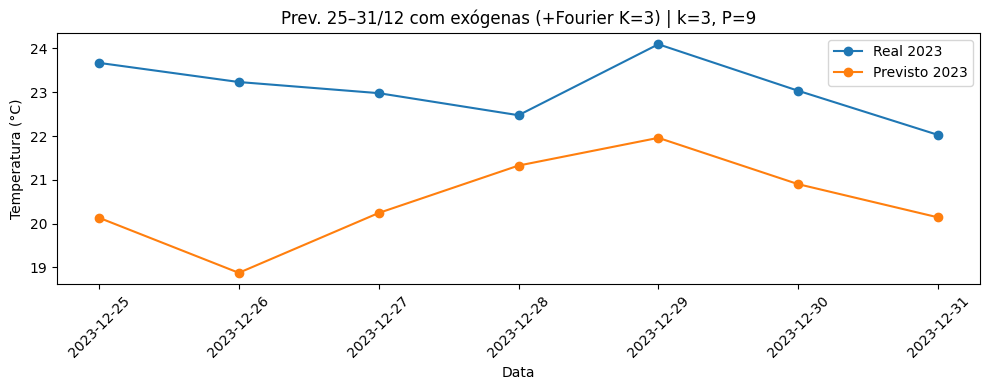

In [6]:
# ===============================================
# PREVISÃO 25–31/12 USANDO k ANOS DE HISTÓRICO + EXÓGENAS + FOURIER
# ===============================================

# --------- IMPORTS BÁSICOS ---------
import os
import re
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# ML / DL
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# --------- CONFIG GERAL ---------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# --------- PARTE 0: UTILITÁRIOS ---------
def slugify(name: str) -> str:
    """Normaliza nomes de coluna: minúsculas, sem acento, troca espaços/símbolos por '_'."""
    s = unicodedata.normalize("NFKD", name).encode("ascii", "ignore").decode("ascii")
    s = s.lower()
    s = re.sub(r"[^a-z0-9]+", "_", s).strip("_")
    return s

def calculate_distance_from_point_to_station(row,
                                             given_point_coord=(-15.760063, -47.871154)):
    station_coord = (row['LATITUDE:'], row['LONGITUDE:'])
    return geodesic(station_coord, given_point_coord).kilometers

def build_agg_spec(exog_vars):
    """
    Define agregação por coluna nas exógenas:
      - se contiver 'radiacao' -> 'sum'
      - caso contrário -> 'mean'
    Retorna:
      exog_agg: {col_original: agg}
      exog_rename: {col_original: nome_slug}
    """
    agg = {}
    rename = {}
    for col in exog_vars:
        col_limp = slugify(col)
        if "radiacao" in col_limp:
            agg[col] = "sum"
        else:
            agg[col] = "mean"
        rename[col] = col_limp
    return agg, rename

def resample_daily_with_exog(df_raw, temperature_col, exog_vars,
                             fill_mode="interpolate", interp_limit=2):
    """
    df_raw: DF horário. Precisa ter coluna 'Data' (ou 'data') OU índice datetime.
    temperature_col: nome da coluna de temperatura (original, não slug).
    exog_vars: lista com nomes originais das colunas exógenas.
    Retorna df diário com colunas:
      'data', 'temperatura', e exógenas slugificadas.
    """
    df = df_raw.copy()

    # Detecta "data"/"Data" como coluna OU usa índice datetime
    date_col = None
    for c in df.columns:
        if c.lower() == "data":
            date_col = c
            break

    if date_col is not None:
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
        df = df.dropna(subset=[date_col]).set_index(date_col)
    else:
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError("df_raw precisa ter coluna 'data'/'Data' ou índice datetime.")
        df.index = pd.to_datetime(df.index, errors="coerce")
        df = df[~df.index.isna()]

    # Coage as colunas a numérico
    cols_needed = [temperature_col] + exog_vars
    for c in cols_needed:
        if c not in df.columns:
            df[c] = np.nan
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Agrega
    exog_agg, exog_rename = build_agg_spec(exog_vars)
    agg_dict = {temperature_col: "mean", **exog_agg}

    daily = df.resample("D").agg(agg_dict)

    # Renomeia
    rename_map = {temperature_col: "temperatura", **exog_rename}
    daily = daily.rename(columns=rename_map)

    # Reindexa calendário e trata faltantes
    full_idx = pd.date_range(daily.index.min(), daily.index.max(), freq="D")
    daily = daily.reindex(full_idx)

    if fill_mode == "interpolate":
        daily = daily.interpolate(method="time", limit=interp_limit)
    elif fill_mode == "ffill":
        daily = daily.ffill()
    elif fill_mode == "bfill":
        daily = daily.bfill()

    return daily.reset_index().rename(columns={"index": "data"})

# --------- PARTE 1: CARREGAMENTO DOS DADOS HORÁRIOS (2019–2024) ---------
# Ajuste estes caminhos conforme seu ambiente
PATH_ALL_STATIONS = "./data/all_stations.csv"
BASE_DIR = "./data/cleaned_data"
YEARS = [2019, 2020, 2021, 2022, 2023]
SUBDIR_PATTERN = "{year}_cleaned"  # ex.: "2019_cleaned"

# Colunas de interesse
temperature_col = "TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)"
exog_vars = [
    "RADIACAO GLOBAL (KJ/m²)",
    "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",
    "UMIDADE RELATIVA DO AR, HORARIA (%)",
]

# Carrega metadados de estações
df_all_stations = pd.read_csv(PATH_ALL_STATIONS, decimal=",", sep=";")
df_all_stations["Distancia"] = df_all_stations.apply(
    calculate_distance_from_point_to_station, axis=1
)
# Filtra estações a até 30 km
df_nearest_stations = df_all_stations[df_all_stations["Distancia"] < 30].copy()
print("Estações próximas (<30km):", len(df_nearest_stations))

# Lê arquivos horários por estação e por ano
weather_frames = []
for filename in df_nearest_stations['Arquivo']:
    for year in YEARS:
        year_dir = os.path.join(BASE_DIR, SUBDIR_PATTERN.format(year=year))
        fname_year = filename.replace("2019", str(year))
        file_path = os.path.join(year_dir, fname_year)
        if not os.path.exists(file_path):
            file_path = os.path.join(year_dir, filename)
        if os.path.exists(file_path):
            df_y = pd.read_csv(file_path, decimal=".", sep=";")
            weather_frames.append(df_y)
        else:
            print("[AVISO] Arquivo não encontrado:", file_path)

if not weather_frames:
    raise FileNotFoundError("Nenhum arquivo horário encontrado. Verifique os caminhos.")

df_hourly_all = pd.concat(weather_frames, ignore_index=True)

# Limpeza simples
if "Hora UTC" in df_hourly_all.columns:
    df_hourly_all = df_hourly_all.drop(columns=["Hora UTC"])
if "Data" not in df_hourly_all.columns:
    raise KeyError("Não encontrei coluna 'Data' nos arquivos horários.")

df_hourly_all["Data"] = pd.to_datetime(df_hourly_all["Data"], errors="coerce")
df_hourly_all = df_hourly_all.dropna(subset=["Data"]).sort_values("Data")

# --------- PARTE 2: RESAMPLE DIÁRIO (temperatura + exógenas) ---------
df_diario = resample_daily_with_exog(
    df_raw=df_hourly_all,
    temperature_col=temperature_col,
    exog_vars=exog_vars,
    fill_mode="interpolate",
    interp_limit=2
)
print("df_diario (head):")
print(df_diario.head())

# >>> FOURIER: criar features sazonais (anual) ----------------------------
def add_fourier_features(df, col_date="data", period=365.2425, K=3, prefix="fourier"):
    """
    Adiciona colunas senoidais/cosenoidais sazonais:
      para k=1..K: sin(2π k * doy / period), cos(2π k * doy / period)
    - period≈365.2425 (ano trópico) por padrão.
    - Usa day-of-year (1..366) para manter a fase anual.
    """
    d = df.copy()
    if col_date not in d.columns:
        raise KeyError(f"Coluna de data '{col_date}' não encontrada.")
    d[col_date] = pd.to_datetime(d[col_date], errors="coerce")
    d = d.dropna(subset=[col_date])

    # dia do ano (1..366), como float
    doy = d[col_date].dt.dayofyear.astype(float)

    for k in range(1, K + 1):
        angle = 2 * np.pi * k * (doy / period)
        d[f"{prefix}_sin_{k}"] = np.sin(angle)
        d[f"{prefix}_cos_{k}"] = np.cos(angle)

    return d

# Adiciona K harmônicos (ajuste K se quiser capturar mais/menos complexidade sazonal)
FOURIER_K = 3
df_diario = add_fourier_features(df_diario, col_date="data", period=365.2425, K=FOURIER_K, prefix="fourier")
# ------------------------------------------------------------------------

# --------- PARTE 3: EXTRAÇÃO DAS SEMANAS 25–31/12 (TEMP + EXÓGENAS) ---------
# Exógenas medidas + as fourier recém-criadas:
exog_cols = [slugify(c) for c in exog_vars]  # nomes (slug) vindos do resample
fourier_cols = [c for c in df_diario.columns if c.startswith("fourier_")]
exog_all_cols = exog_cols + fourier_cols

def extrair_semanas_dezembro_com_exog(df, exog_cols, start_day="12-25", end_day="12-31", impute=True):
    """
    Retorna:
      temps: (N, 7)
      exogs: (N, 7, P)  [P = nº exógenas em exog_cols]
      anos:  (N,)
    """
    d = df.copy()
    d["data"] = pd.to_datetime(d["data"], errors="coerce")
    d = d.dropna(subset=["data"]).sort_values("data")

    anos = np.sort(d["data"].dt.year.unique())
    T_list, E_list, A_list = [], [], []

    for ano in anos:
        dt_ini = pd.to_datetime(f"{ano}-{start_day}", errors="coerce")
        dt_fim = pd.to_datetime(f"{ano}-{end_day}", errors="coerce")
        sem = d[(d["data"] >= dt_ini) & (d["data"] <= dt_fim)].sort_values("data")

        if len(sem) != 7:
            print(f"[AVISO] {ano}: intervalo {start_day}–{end_day} tem {len(sem)} dia(s). Ignorado.")
            continue

        # temperatura
        t = pd.to_numeric(sem["temperatura"], errors="coerce").to_numpy(dtype=float)

        # exógenas (cada uma vira um vetor de 7)
        e_cols_presentes = []
        for c in exog_cols:
            if c not in sem.columns:
                sem[c] = np.nan
            e_cols_presentes.append(pd.to_numeric(sem[c], errors="coerce").to_numpy(dtype=float))
        e = np.vstack(e_cols_presentes).T  # (7, P)

        if impute:
            # Imputação leve por coluna (temp + cada exógena)
            t = pd.Series(t).interpolate(limit_direction="both").to_numpy()
            e_imp = []
            for j in range(e.shape[1]):
                e_imp.append(pd.Series(e[:, j]).interpolate(limit_direction="both").to_numpy())
            e = np.vstack(e_imp).T  # volta para (7, P)

        # Checagem de finitude
        if np.isnan(t).any() or ~np.isfinite(t).all():
            print(f"[AVISO] {ano}: temperatura com NaN/Inf. Ignorado.")
            continue
        if np.isnan(e).any() or ~np.isfinite(e).all():
            print(f"[AVISO] {ano}: exógenas com NaN/Inf. Ignorado.")
            continue

        T_list.append(t)
        E_list.append(e)
        A_list.append(ano)

    if not T_list:
        raise ValueError("Nenhuma semana válida encontrada (temp/exógenas).")

    temps = np.vstack(T_list)            # (N, 7)
    exogs = np.stack(E_list, axis=0)     # (N, 7, P)
    anos  = np.array(A_list, dtype=int)
    return temps, exogs, anos

temps, exogs, anos = extrair_semanas_dezembro_com_exog(df_diario, exog_all_cols, impute=True)
N, P = exogs.shape[0], exogs.shape[2]
print(f"Semanas válidas: {N} | Exógenas (incl. Fourier): {P} -> {exog_all_cols} | Anos: {anos.tolist()}")

# --------- PARTE 4: JANELAS DESLIZANTES COM EXÓGENAS ---------
def montar_janelas_com_exog(temps, exogs, anos, k=4):
    """
    Para cada t >= k, X concatena as semanas [t-k, ..., t-1] de:
      [temp(7), exog1(7), ..., exogP(7)] por lag
    -> X dim = 7*(1+P)*k
    y  = temp da semana t (7,)
    """
    X_list, y_list, anos_alvo = [], [], []
    N, _, P = exogs.shape
    for t in range(k, N):
        blocos = []
        for lag in range(t-k, t):
            blocos.append(temps[lag])                 # (7,)
            blocos.append(exogs[lag].T.reshape(-1))   # (P,7) -> (7P,)
        x = np.concatenate(blocos)                    # 7*(1+P)*k
        X_list.append(x)
        y_list.append(temps[t])
        anos_alvo.append(anos[t])
    return np.vstack(X_list), np.vstack(y_list), np.array(anos_alvo)

def escolher_k_adaptativo(n_anos, max_k=4, min_pares=2):
    """
    Escolhe maior k <= max_k com (n_anos - k) >= min_pares.
    Caso extremo, retorna max(1, n_anos-1).
    """
    for k in range(max_k, 0, -1):
        if n_anos - k >= min_pares:
            return k
    return max(1, n_anos - 1)

k = escolher_k_adaptativo(N, max_k=4, min_pares=2)
print(f"k escolhido: {k} (janelas = {N-k})")

X, y, anos_alvo = montar_janelas_com_exog(temps, exogs, anos, k=k)
print("Shapes -> X:", X.shape, " | y:", y.shape)

# Limpeza de segurança
ok = np.isfinite(X).all(axis=1) & np.isfinite(y).all(axis=1)
if not ok.all():
    print(f"[AVISO] removendo {(~ok).sum()} janelas com NaN/Inf.")
    X, y, anos_alvo = X[ok], y[ok], anos_alvo[ok]
if len(X) == 0:
    raise ValueError("Sem janelas válidas após limpeza.")

# --------- PARTE 5: SPLIT TEMPORAL + NORMALIZAÇÃO ---------
if len(X) == 1:
    X_train, y_train = X, y
    X_test,  y_test  = X, y
    ano_teste = anos_alvo[-1]
    print("[ATENÇÃO] Só 1 janela disponível; métrica não é robusta.")
else:
    X_train, y_train = X[:-1], y[:-1]
    X_test,  y_test  = X[-1:], y[-1:]
    ano_teste = anos_alvo[-1]

scaler = StandardScaler()
scaler.fit(X_train)
X_train_n = scaler.transform(X_train)
X_test_n  = scaler.transform(X_test)

# --------- PARTE 6: MODELO MLP ---------
in_features = X_train_n.shape[1]  # = 7*(1+P)*k
out_features = 7

class MLPExog(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, out_features),
        )
    def forward(self, x):
        return self.net(x)

modelo = MLPExog(in_features, out_features).to(DEVICE)
crit = nn.MSELoss()
opt = torch.optim.Adam(modelo.parameters(), lr=1e-3, weight_decay=1e-4)

Xtr_t = torch.tensor(X_train_n, dtype=torch.float32).to(DEVICE)
ytr_t = torch.tensor(y_train,   dtype=torch.float32).to(DEVICE)

EPOCHS = 500
for ep in range(1, EPOCHS+1):
    modelo.train()
    opt.zero_grad()
    pred = modelo(Xtr_t)
    loss = crit(pred, ytr_t)
    if not torch.isfinite(loss):
        raise ValueError("Loss virou NaN/Inf. Cheque os dados.")
    loss.backward()
    opt.step()
    if ep % 50 == 0:
        print(f"Época {ep}/{EPOCHS} | Loss={loss.item():.4f}")

# --------- PARTE 7: PREVISÃO, RMSE E PLOT ---------
Xt_t = torch.tensor(X_test_n, dtype=torch.float32).to(DEVICE)
modelo.eval()
with torch.no_grad():
    yhat = modelo(Xt_t).cpu().numpy()[0]

valores_reais = y_test[0]
rmse = np.sqrt(mean_squared_error(valores_reais, yhat))
print(f"\nRMSE (25–31/12) com exógenas + Fourier(K={FOURIER_K}), k={k}, alvo {ano_teste}: {rmse:.3f} °C")

# Datas do último ano para plot
mask_plot = (
    (df_diario['data'].dt.year == ano_teste) &
    (df_diario['data'].dt.month == 12) &
    (df_diario['data'].dt.day >= 25) &
    (df_diario['data'].dt.day <= 31)
)
datas_semana_final = df_diario.loc[mask_plot, 'data'].sort_values().values

plt.figure(figsize=(10,4))
plt.plot(datas_semana_final, valores_reais, marker="o", label=f"Real {ano_teste}")
plt.plot(datas_semana_final, yhat,          marker="o", label=f"Previsto {ano_teste}")
plt.title(f"Prev. 25–31/12 com exógenas (+Fourier K={FOURIER_K}) | k={k}, P={P}")
plt.xlabel("Data"); plt.ylabel("Temperatura (°C)")
plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


In [7]:
# ==============================================================
# PREVISÃO DIÁRIA COM EXÓGENAS (+ FOURIER) E AVALIAÇÃO SÓ NA ÚLTIMA SEMANA
# ==============================================================

# ---------- Imports ----------
import numpy as np
import pandas as pd
import unicodedata, re
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

torch.manual_seed(1)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

# ---------- Parâmetros ----------
N_PAST = 7          # janela: 7 dias -> prevê 1 dia
BATCH  = 32
EPOCHS = 150
LR     = 1e-3

temperature_col = "TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)"
exog_vars = [
    "RADIACAO GLOBAL (KJ/m²)",
    "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",
    "UMIDADE RELATIVA DO AR, HORARIA (%)",
]

# ---------- Utils ----------
def slugify(name: str) -> str:
    s = unicodedata.normalize("NFKD", name).encode("ascii", "ignore").decode("ascii")
    s = s.lower()
    s = re.sub(r"[^a-z0-9]+", "_", s).strip("_")
    return s

def build_agg_spec(exog_vars):
    agg, rename = {}, {}
    for col in exog_vars:
        col_limp = slugify(col)
        agg[col] = "sum" if "radiacao" in col_limp else "mean"
        rename[col] = col_limp
    return agg, rename

def resample_daily_with_exog(df_raw, temperature_col, exog_vars,
                             fill_mode="interpolate", interp_limit=2):
    """
    Aceita DF com coluna 'data'/'Data' OU índice datetime.
    Retorna DF diário com colunas: data, temperatura e exógenas (slugificadas).
    """
    df = df_raw.copy()

    # Detecta 'data'/'Data' ou usa índice
    date_col = None
    for c in df.columns:
        if c.lower() == "data":
            date_col = c
            break
    if date_col is not None:
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
        df = df.dropna(subset=[date_col]).set_index(date_col)
    else:
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError("Forneça coluna 'data'/'Data' ou índice datetime.")
        df.index = pd.to_datetime(df.index, errors="coerce")
        df = df[~df.index.isna()]

    # Garante numérico nas colunas necessárias
    cols_needed = [temperature_col] + exog_vars
    for c in cols_needed:
        if c not in df.columns:
            df[c] = np.nan
        df[c] = pd.to_numeric(df[c], errors="coerce")

    exog_agg, exog_rename = build_agg_spec(exog_vars)
    agg_dict = {temperature_col: "mean", **exog_agg}

    daily = df.resample("D").agg(agg_dict)

    rename_map = {temperature_col: "temperatura", **exog_rename}
    daily = daily.rename(columns=rename_map)

    # calendário completo + preenchimento leve
    full_idx = pd.date_range(daily.index.min(), daily.index.max(), freq="D")
    daily = daily.reindex(full_idx)

    if fill_mode == "interpolate":
        daily = daily.interpolate(method="time", limit=interp_limit)
    elif fill_mode == "ffill":
        daily = daily.ffill()
    elif fill_mode == "bfill":
        daily = daily.bfill()

    return daily.reset_index().rename(columns={"index": "data"})

def add_fourier_features(df, periods=(365.25,), K=3, date_col="data"):
    """
    Adiciona séries de Fourier anuais: para cada período P e k=1..K,
    cria sin(2π k t/P) e cos(2π k t/P).
    """
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col])
    # tempo contínuo em dias
    t = (d[date_col] - d[date_col].min()).dt.total_seconds() / (24*3600)
    for P in periods:
        for k in range(1, K+1):
            d[f"fourier_sin_p{int(P)}_k{k}"] = np.sin(2*np.pi*k*t/P)
            d[f"fourier_cos_p{int(P)}_k{k}"] = np.cos(2*np.pi*k*t/P)
    return d

def make_sequences_features(df_feat, cols_feat, n_past):
    """
    Constrói janelas com TODAS as features (temperatura, exógenas e Fourier)
    para prever 1 passo à frente da variável-alvo (temperatura).
    """
    X, y = [], []
    arr = df_feat[cols_feat].values
    tgt = df_feat["temperatura"].values
    for i in range(n_past, len(df_feat)):
        X.append(arr[i-n_past:i].reshape(-1))  # concatena janela (n_past * n_features)
        y.append(tgt[i])
    return np.array(X), np.array(y)

class RedeClimaticaExog(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
    def forward(self, x): return self.net(x)

def walkforward_eval_last_week(df_feat, cols_feat, n_past, scaler_X, scaler_y, model, k=7):
    """
    Faz previsões nos últimos k dias, cada dia usando os n_past dias anteriores.
    Não extrapola para o futuro (apenas backtest da última semana).
    """
    df_feat = df_feat.sort_values("data").reset_index(drop=True)
    idx_start = len(df_feat) - k
    preds_scaled, datas = [], []

    for i in range(idx_start, len(df_feat)):
        if i - n_past < 0:
            raise ValueError("Série muito curta para o n_past escolhido.")
        window = df_feat[cols_feat].iloc[i-n_past:i].values.reshape(1, -1)
        Xn = scaler_X.transform(window)
        with torch.no_grad():
            yhat_s = model(torch.tensor(Xn, dtype=torch.float32).to(DEVICE)).cpu().numpy().item()
        preds_scaled.append(yhat_s)
        datas.append(df_feat["data"].iloc[i])

    y_pred = scaler_y.inverse_transform(np.array(preds_scaled).reshape(-1,1)).flatten()
    y_true = df_feat["temperatura"].iloc[-k:].values
    datas  = pd.to_datetime(pd.Series(datas)).values
    return datas, y_pred, y_true

# ==============================================================
# 1) Monta DF diário com temperatura + exógenas
#    -> aqui uso df_not_null_values_day como no seu código anterior.
#    Se você tiver o DF horário bruto, troque a chamada por ele.
# ==============================================================

# df_not_null_values_day deve existir do seu pipeline anterior:
# - índice datetime
# - já em frequência diária
# - sem nulos (ffill feito antes)
# Caso não exista, lance um erro amigável.
if 'df_not_null_values_day' not in globals():
    raise RuntimeError("Defina 'df_not_null_values_day' (DF diário, sem nulos), como no seu pipeline anterior.")

# Usa a função para padronizar nomes e garantir colunas esperadas
df_diario = resample_daily_with_exog(
    df_raw=df_not_null_values_day.reset_index().rename(columns={"index": "Data"}),  # compat
    temperature_col=temperature_col,
    exog_vars=exog_vars,
    fill_mode="interpolate",
    interp_limit=2
)

# ==============================================================
# 2) Adiciona Fourier e prepara matriz de features
# ==============================================================

# mantém as exógenas com nomes slug
exog_cols = [slugify(c) for c in exog_vars]

# Fourier anual com K harmônicos (ajuste K se quiser mais/menos suavização sazonal)
df_feat = add_fourier_features(df_diario, periods=(365.25,), K=3, date_col="data")

fourier_cols = [c for c in df_feat.columns if c.startswith("fourier_")]
exog_all_cols = exog_cols + fourier_cols

# Colunas de entrada = temperatura (como covariável) + exógenas + fourier
cols_feat = ["temperatura"] + exog_all_cols

# Remove linhas com NaN remanescentes (se houver)
df_feat = df_feat.dropna(subset=["temperatura"] + exog_all_cols).sort_values("data").reset_index(drop=True)

# ==============================================================
# 3) Sequências (N_PAST) e split temporal (80/20)
# ==============================================================

X, y = make_sequences_features(df_feat, cols_feat, N_PAST)

split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test,  y_test  = X[split:], y[split:]

# Scalers (X multivariado; y escalar)
scaler_X = StandardScaler()
scaler_y = MinMaxScaler()

X_train_n = scaler_X.fit_transform(X_train)
X_test_n  = scaler_X.transform(X_test)

y_train_n = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_n  = scaler_y.transform(y_test.reshape(-1,1)).flatten()

# Tensores
X_train_t = torch.tensor(X_train_n, dtype=torch.float32).to(DEVICE)
y_train_t = torch.tensor(y_train_n, dtype=torch.float32).unsqueeze(1).to(DEVICE)
X_test_t  = torch.tensor(X_test_n , dtype=torch.float32).to(DEVICE)
y_test_t  = torch.tensor(y_test_n , dtype=torch.float32).unsqueeze(1).to(DEVICE)

loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH, shuffle=True, drop_last=False)

# ==============================================================
# 4) Treino
# ==============================================================

model = RedeClimaticaExog(in_dim=X_train_t.shape[1]).to(DEVICE)
crit  = nn.MSELoss()
opt   = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(1, EPOCHS + 1):
    model.train()
    for xb, yb in loader:
        opt.zero_grad()
        loss = crit(model(xb), yb)
        loss.backward()
        opt.step()
    if epoch % 30 == 0:
        print(f"Epoch {epoch:3}/{EPOCHS} | loss={loss.item():.6f}")

# ==============================================================
# 5) Avaliação GLOBAL no conjunto de teste (opcional)
# ==============================================================

model.eval()
with torch.no_grad():
    y_pred_test_s = model(X_test_t).squeeze().cpu().numpy()

y_pred_test = scaler_y.inverse_transform(y_pred_test_s.reshape(-1,1)).flatten()
y_test_inv  = scaler_y.inverse_transform(y_test_t.cpu()).flatten()

rmse_test = np.sqrt(mean_squared_error(y_test_inv, y_pred_test))
print(f"\nRMSE no bloco de teste (80/20): {rmse_test:.3f} °C")

# Curva de teste (opcional)
datas_test = df_feat["data"].iloc[N_PAST+split:N_PAST+len(X)]
plt.figure(figsize=(12,4))
plt.plot(datas_test, y_test_inv , label="Real (teste)")
plt.plot(datas_test, y_pred_test, label="Previsto (teste)")
plt.title("Desempenho no conjunto de teste")
plt.xlabel("Data"); plt.ylabel("Temperatura (°C)")
plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

# ==============================================================
# 6) **Backtest** apenas na última semana (sem forecast futuro)
# ==============================================================

datas_eval, preds_eval, ytrue_eval = walkforward_eval_last_week(
    df_feat=df_feat, cols_feat=cols_feat, n_past=N_PAST,
    scaler_X=scaler_X, scaler_y=scaler_y, model=model, k=7
)

rmse_eval = np.sqrt(mean_squared_error(ytrue_eval, preds_eval))
print(f"RMSE dos últimos 7 dias (walk-forward): {rmse_eval:.3f} °C")

plt.figure(figsize=(12,4))
plt.plot(datas_eval, ytrue_eval, label="Real (últimos 7 dias)")
plt.plot(datas_eval, preds_eval, "o-", label="Previsto (últimos 7 dias)")
plt.fill_between(datas_eval, preds_eval - rmse_eval, preds_eval + rmse_eval,
                 alpha=.25, color="tab:red", label="± RMSE")
plt.title("Previsão nos últimos 7 dias (Temp + Exógenas + Fourier)")
plt.xlabel("Data"); plt.ylabel("Temperatura (°C)")
plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


DEVICE: cuda


RuntimeError: Defina 'df_not_null_values_day' (DF diário, sem nulos), como no seu pipeline anterior.